In [1]:
from json import loads
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")
from pyspark.sql.functions import col,from_json,udf
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,MapType,FloatType,ArrayType

In [2]:
spark = SparkSession.\
        builder.\
        appName("process-data").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1024m").\
        getOrCreate()

22/11/16 14:36:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = spark.read.parquet('hdfs://namenode:9000/tiki/Comment')

In [4]:
sample_data = data.select('value').take(1)

In [5]:
sample_data = sample_data[0].value

In [6]:
data_sample = loads(sample_data)

In [7]:
schema = StructType([ 
    StructField("id",IntegerType(),True), 
    StructField("content",StringType(),True), 
    StructField("thank_count",IntegerType(),True), 
    StructField("customer_id",IntegerType(),True),
    StructField("rating",IntegerType(),True), 
    StructField("created_by",MapType(StringType(),StringType()),True),
    StructField("spid",IntegerType(),True),
    StructField("seller",MapType(StringType(),StringType()),True),
    StructField('product_id', IntegerType(),True),
])

In [8]:
df = data.withColumn("jsonData",from_json(col("value"),schema)) \
                   .select("jsonData.*")

In [9]:
df.createOrReplaceTempView('Comment')

In [10]:
import re
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>') 
def cleanText(str_raw):
    # remove tags html
    str_raw = re.sub(CLEANR, ' ', str_raw)

    # remove special character
    str_raw = re.sub('\W+', ' ', str_raw)
    
    # remove number
    str_raw = re.sub("[0-9]+", "", str_raw)
    
    # remove space
    cleantext = re.sub(" +", " ", str_raw)
    return cleantext.lower()

In [11]:
spark.udf.register("cleanText", cleanText,StringType())

<function __main__.cleanText(str_raw)>

In [12]:
df_clean = spark.sql("""
    select id,content contentRaw,cleanText(content) content,thank_count,customer_id,rating,spid,product_id, created_by.full_name customer_full_name,created_by.purchased_at purchased_at,
    from_unixtime(CAST(created_by.purchased_at as BIGINT), 'yyyy-MM-dd') date_purchased_at,
    case
        when rating >= 4 then 'Positive'
        when rating = 3 then 'Neutral'
        when rating <3 then 'Negative'
    end as sentiment,
    case
        when rating >= 4 then 2
        when rating = 3 then 1
        when rating <3 then 0
    end as lable
    from Comment c
""")

In [ ]:
df_clean.write.mode('append').parquet('hdfs://namenode:9000/TikiCleaned/Comment')

In [ ]:
df_product = spark.read.parquet('hdfs://namenode:9000/TikiCleaned/Product')

In [ ]:
df_product.show()

In [4]:
from pyspark.sql.functions import col,from_json

In [5]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,MapType
schema = StructType([ 
    StructField("id",StringType(),True), 
    StructField("title",StringType(),True), 
    StructField("thank_count",StringType(),True), 
    StructField("content",StringType(),True),
    StructField("rating",IntegerType(),True), 
    StructField("spid",IntegerType(),True),
    StructField("product_id",IntegerType(),True),
    StructField('created_by', MapType(StringType(),StringType()),True),
    StructField('seller', MapType(StringType(),StringType()),True),
    StructField('timeline', MapType(StringType(),StringType()),True)
  ])

In [6]:
df = data.withColumn("jsonData",from_json(col("value"),schema)) \
                   .select("jsonData.*")

In [58]:
df.count()

4284135

In [63]:
data = df.select(['title','rating','thank_count','content']).filter("content is not null and content <> ''").limit(1000)

In [64]:
data.write.format(
    "org.elasticsearch.spark.sql"
).option(
    "es.resource", '%s/%s' % ('item2', 'data')
).option(
    "es.nodes", 'es01'
).option(
    "es.port", 9200
).save()

22/11/04 19:26:31 WARN Resource: Detected type name in resource [item2/data]. Type names are deprecated and will be removed in a later release.


In [7]:
df.createOrReplaceTempView('comment')

In [74]:
spark.sql("""
        select * from comment
        where content = '' or content is null
        limit 10
""").show()

+--------+---------------+-----------+-------+------+---------+----------+----------+--------------------+--------------------+--------------------+
|      id|          title|thank_count|content|rating|     spid|product_id|product_id|          created_by|              seller|            timeline|
+--------+---------------+-----------+-------+------+---------+----------+----------+--------------------+--------------------+--------------------+
|17875450|Cực kì hài lòng|          0|       |     5|  2413305|      null|    980512|[id -> 13848315, ...|[id -> 4189, name...|[review_created_d...|
|16658534|Cực kì hài lòng|          0|       |     5|  2413305|      null|    980512|[id -> 14960284, ...|[id -> 4189, name...|[review_created_d...|
|17875450|Cực kì hài lòng|          0|       |     5|  2413305|      null|    980512|[id -> 13848315, ...|[id -> 4189, name...|[review_created_d...|
|16658534|Cực kì hài lòng|          0|       |     5|  2413305|      null|    980512|[id -> 14960284, ...|

In [9]:
spark.sql("""
        select count(*) from comment
        where content = '' or content is null
""").show()

+--------+
|count(1)|
+--------+
|  295616|
+--------+



In [10]:
df.count()

4284135

In [13]:
spark.sql("""
        select rating,count(*) as num_comments from comment
        where content <> '' and content is not null
        group by rating
        order by rating
""").show()

+------+------------+
|rating|num_comments|
+------+------------+
|     1|      202244|
|     2|       73837|
|     3|      133501|
|     4|      190246|
|     5|     3388691|
+------+------------+



In [12]:
spark.sql("""
        select rating,count(*) as num_comments from comment
        group by rating
        order by rating
""").show()

+------+------------+
|rating|num_comments|
+------+------------+
|     1|      202435|
|     2|       73966|
|     3|      137486|
|     4|      217452|
|     5|     3652796|
+------+------------+



In [73]:
spark.sql("""
        select 
        sum(if(rating<=2,1,0)) negative,
        sum(if(rating=3,1,0)) neutral,
        sum(if(rating>=4,1,0)) postive
        from comment
        where (content != '' or content is not null)
""").show()

+--------+-------+-------+
|negative|neutral|postive|
+--------+-------+-------+
|  276401| 137486|3870248|
+--------+-------+-------+



In [80]:
spark.sql("""
        select 
        created_by.id
        from comment
        where content != '' or content is not null
        limit 10
""").show()

+--------+
|      id|
+--------+
|12554841|
|18025738|
|14802933|
|18244433|
|15856769|
|22757127|
| 9871953|
|24852549|
|20480308|
|12800332|
+--------+



In [83]:
spark.sql("""
        select created_by.id, count(*) cus_comments
        from comment
        where content != '' or content is not null
        group by created_by.id
        order by cus_comments desc
        limit 10
""").show()

+--------+------------+
|      id|cus_comments|
+--------+------------+
| 7178520|        7832|
| 6492212|        4714|
|  494671|        2819|
|    null|        2809|
|  858200|        2013|
|25936457|        2001|
|19763709|        1862|
| 1642224|        1840|
|18025738|        1745|
| 7423818|        1680|
+--------+------------+



In [84]:
spark.sql("""
        select 
        *
        from comment
        where (content != '' or content is not null)
        and created_by.id = 7178520
        limit 10
""").show()

+--------+---------------+-----------+--------------------+------+--------+----------+----------+--------------------+--------------------+--------------------+
|      id|          title|thank_count|             content|rating|    spid|product_id|product_id|          created_by|              seller|            timeline|
+--------+---------------+-----------+--------------------+------+--------+----------+----------+--------------------+--------------------+--------------------+
|16708272|Cực kì hài lòng|          0|Sản phẩm có chất ...|     5|75953558|      null|  75953557|[id -> 7178520, n...|[id -> 1, name ->...|[review_created_d...|
|16708272|Cực kì hài lòng|          0|Sản phẩm có chất ...|     5|75953558|      null|  75953557|[id -> 7178520, n...|[id -> 1, name ->...|[review_created_d...|
|16708272|Cực kì hài lòng|          0|Sản phẩm có chất ...|     5|75953558|      null|  75953557|[id -> 7178520, n...|[id -> 1, name ->...|[review_created_d...|
|16708272|Cực kì hài lòng|        

In [13]:
data_sample

{'id': 15477570,
 'title': 'Cực kì hài lòng',
 'content': 'Lần đầu tiên mua sách trên tiki thật sự khiến mình rất hài lòng ạ. Shipper khá thân thiện, thời gian giao hàng nhanh đóng gói đẹp và chắc chắn, sách về đến tay mình không móp méo gì cả. Nói chung là rất tuyệt vời, hy vọng những lần sau khi quay lại ủng hộ tiki vẫn khiến mình có một cảm giác thật hạnh phúc khi nhận hàng như hôm nay🥰…',
 'status': 'approved',
 'thank_count': 2,
 'score': 0.021194,
 'new_score': 0.14524732,
 'customer_id': 12554841,
 'comment_count': 0,
 'rating': 5,
 'images': [{'id': 3245878,
   'full_path': 'https://salt.tikicdn.com/ts/review/19/12/32/38c161fb0f8eedf35c452097d473df4b.jpg',
   'status': 'approved'},
  {'id': 3245879,
   'full_path': 'https://salt.tikicdn.com/ts/review/4a/56/27/6503f6372e278ff379cef8e3cb7da0e6.jpg',
   'status': 'approved'},
  {'id': 3245880,
   'full_path': 'https://salt.tikicdn.com/ts/review/e3/d9/f0/fb5542ea2e294156b95e4dc5c6b54f29.jpg',
   'status': 'approved'},
  {'id': 3245

In [11]:
from pyspark.sql.functions import expr

In [14]:
df1 = df.withColumn('label',expr("""
    case
        when rating <= 2 THEN 0
        when rating = 3 THEN 1
        when rating > 3 THEN 2
    end
    """))

In [15]:
df1 = df1.filter('content is not null')

In [16]:
dataset1 = df1.filter(df1.label == 0).limit(1000)
dataset2 = df1.filter(df1.label == 1).limit(1000)
dataset3 = df1.filter(df1.label == 2).limit(1000)

In [17]:
datasetAll = dataset1.union(dataset2).union(dataset3)

In [20]:
newData = datasetAll.toPandas()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newData.content)

In [24]:
X = X.toarray()

In [26]:
X.shape

(3000, 1444)

In [28]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
pca_samples = pca.transform(X)

In [29]:
import pandas as pd

In [30]:
pca = PCA(n_components=25)

matrix_9D = pca.fit_transform(X)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(newData.label)

In [32]:
mat.shape

(3000, 26)

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

res = cosine_similarity(X)

In [55]:
res

array([[1.        , 0.03385829, 0.08387336, ..., 0.03898354, 0.20797736,
        0.        ],
       [0.03385829, 1.        , 0.        , ..., 0.07642494, 0.04012343,
        0.        ],
       [0.08387336, 0.        , 1.        , ..., 0.00790578, 0.13905466,
        0.        ],
       ...,
       [0.03898354, 0.07642494, 0.00790578, ..., 1.        , 0.11334898,
        0.22344245],
       [0.20797736, 0.04012343, 0.13905466, ..., 0.11334898, 1.        ,
        0.15229854],
       [0.        , 0.        , 0.        , ..., 0.22344245, 0.15229854,
        1.        ]])

<AxesSubplot: >

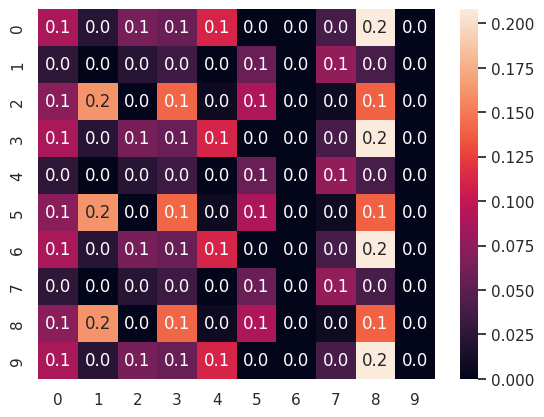

In [54]:
sns.heatmap(res[:10,-10:], annot=True, fmt=".1f")

<AxesSubplot: >

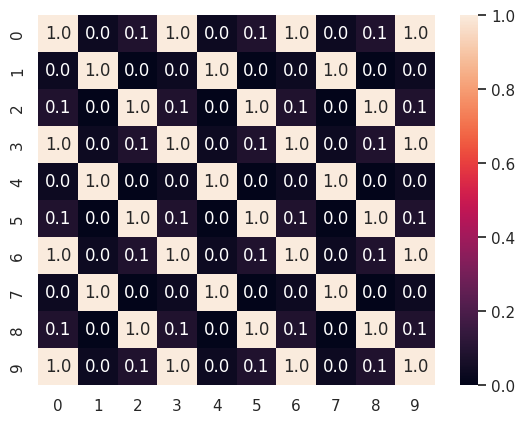

In [53]:
sns.heatmap(res[:10,:10], annot=True, fmt=".1f")

In [33]:
mat.to_csv('mat.csv')

In [16]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- thank_count: string (nullable = true)
 |-- content: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- spid: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- created_by: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- seller: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- timeline: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- label: integer (nullable = true)



In [25]:
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import lower, col, split

dataset = df.select(lower(col('content')).alias('content'), 'label')
dataset = dataset.select(split(dataset.content, ' ').alias('content'), 'label')

In [27]:
dataset1 = dataset.filter(dataset.label == 0).limit(1000)
dataset2 = dataset.filter(dataset.label == 1).limit(1000)
dataset3 = dataset.filter(dataset.label == 2).limit(1000)

In [28]:
datasetAll = dataset1.union(dataset2).union(dataset3)

In [97]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
# tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
# wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="content", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(datasetAll)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [100]:
rescaledData.select('features').take(5)

[Row(features=SparseVector(20, {1: 0.8378, 2: 0.7026, 3: 0.4143, 4: 1.7441, 5: 1.7353, 6: 0.9383, 7: 1.7376, 8: 0.9782, 11: 1.0913, 12: 1.0362, 13: 1.6224, 14: 1.8642, 15: 2.4079, 16: 0.7409, 18: 0.6065, 19: 0.5045})),
 Row(features=SparseVector(20, {0: 0.4199, 2: 0.7026, 5: 0.3471, 6: 0.3128, 7: 0.6951, 9: 0.3685, 11: 0.5456, 13: 1.6224, 15: 0.903, 16: 2.2226, 17: 0.4693, 18: 0.3032, 19: 0.5045})),
 Row(features=SparseVector(20, {0: 0.8398, 1: 0.4189, 2: 0.7026, 4: 0.5814, 5: 0.3471, 6: 0.3128, 7: 0.3475, 8: 0.6521, 9: 0.3685, 11: 0.5456, 12: 1.2089, 13: 1.352, 15: 0.301, 18: 0.9097, 19: 0.5045})),
 Row(features=SparseVector(20, {0: 0.8398, 3: 0.4143, 8: 0.6521, 12: 0.3454, 13: 0.5408, 14: 1.1185, 15: 0.602, 16: 0.7409, 18: 0.3032, 19: 0.5045})),
 Row(features=SparseVector(20, {0: 2.0995, 1: 1.2567, 3: 1.6573, 4: 3.4882, 5: 4.1647, 6: 3.1276, 7: 0.6951, 8: 1.9564, 9: 1.1055, 10: 4.8488, 11: 1.0913, 12: 1.2089, 13: 1.8928, 14: 1.4914, 15: 1.8059, 16: 0.3704, 17: 2.3464, 18: 3.6389, 19:

In [29]:
word2Vec = Word2Vec(vectorSize=100, seed=42, inputCol="content", outputCol="features")
word2Vec.setMaxIter(5)
model = word2Vec.fit(datasetAll)

res = model.transform(datasetAll)

In [31]:
res.groupby('label').count().show()

22/11/03 17:02:16 WARN TaskSetManager: Lost task 0.0 in stage 5.0 (TID 68, 172.20.0.12, executor 1): TaskKilled (Stage cancelled)


+-----+-----+
|label|count|
+-----+-----+
|    1| 1000|
|    2| 1000|
|    0| 1000|
+-----+-----+



In [36]:
import numpy as np

In [38]:
arr = np.array(res.select('features').collect())

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:58)


In [39]:
label = np.array(res.select('label').collect())

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [48]:
arr = arr.reshape(3000,100)

In [50]:
label

array([[0],
       [0],
       [0],
       ...,
       [2],
       [2],
       [2]])

In [61]:
matrix = cosine_similarity(arr)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
pca = PCA()
pca.fit(arr)
pca_samples = pca.transform(arr)

In [68]:
matrix = arr

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

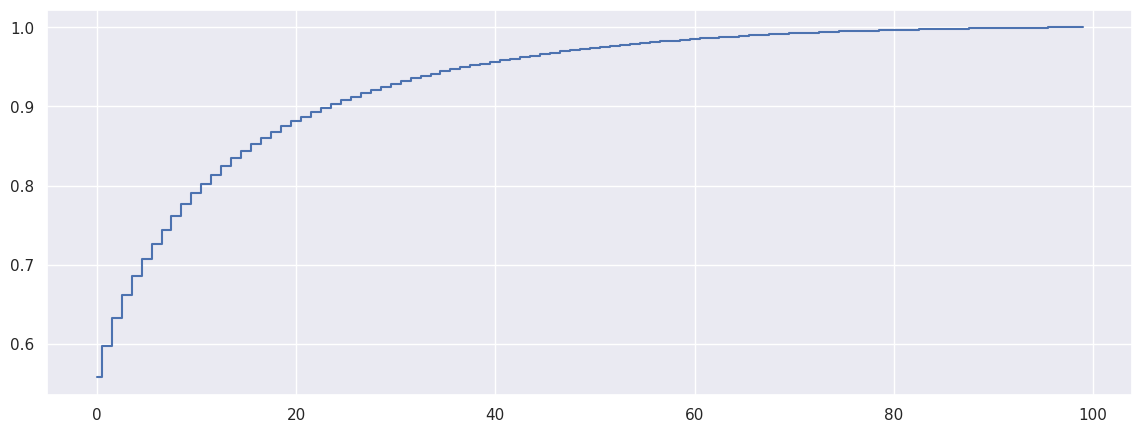

In [69]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [71]:
import pandas as pd

In [74]:
label.shape

(3000, 1)

In [75]:
label= label.reshape(-1)

In [76]:
pca = PCA(n_components=25)

matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(label)

In [81]:
mat

0         1         2         3         4         5         6  \
0    -0.388450 -0.122346  0.053493 -0.022811 -0.065821 -0.075277 -0.034579   
1    -0.288823  0.121006  0.084765  0.142700 -0.442822  0.497069  0.187506   
2    -0.362852  0.169387  0.176595 -0.180389 -0.218464 -0.058302 -0.070605   
3    -0.173589  0.077224  0.025845  0.112257 -0.073783  0.186143  0.015452   
4    -0.249168 -0.057439  0.099079  0.070891 -0.140830  0.041971  0.022034   
...        ...       ...       ...       ...       ...       ...       ...   
2995 -0.408387  0.028667 -0.297150 -0.019318  0.032702  0.135601  0.208418   
2996 -0.201618 -0.067507  0.071069  0.099468 -0.249712 -0.035515  0.017083   
2997 -0.209909 -0.086263  0.066137  0.176862 -0.080505  0.122891 -0.010943   
2998 -0.298074 -0.071333 -0.052765  0.012173 -0.067715 -0.143194 -0.025040   
2999 -0.280926 -0.122472  0.129348  0.098555  0.015720 -0.141635 -0.032872   

             7         8         9  ...        16        17        18  \
0     0.065156 -0.017903 -0.061066  ...  0.015360  0.037669 -0.018194   
1     0.265648 -0.115171 -0.253648  ... -0.157021  0.116678 -0.034308   
2     0.016777 -0.013787  0.064006  ...  0.012765  0.011696 -0.151548   
3     0.058257  0.141389 -0.039720  ... -0.052034  0.248283 -0.141029   
4    -0.036977  0.101641  0.030531  ... -0.021020 -0.015303  0.012140   
...        ...       ...       ...  ...       ...       ...       ...   
2995 -0.199706  0.305718 -0.062529  ...  0.083849 -0.282023 -0.202033   
2996  0.082034 -0.113705  0.218120  ...  0.051525  0.043295  0.073432   
2997  0.050592  0.075067 -0.051704  ...  0.093897 -0.040139 -0.151805   
2998  0.045942 -0.017971 -0.138151  ...  0.018877 -0.020298 -0.170907   
2999  0.093571 -0.002207  0.033279  ...  0.151924 -0.111619 -0.210384   

            19        20        21        22        23        24  cluster  
0    -0.079678 -0.142789  0.015903  0.053995 -0.016090 -0.019614        0  
1    -0.100250 -0.023080 -0.328351  0.144501 -0.147166 -0.243157        0  
2    -0.211200  0.056145 -0.012926  0.041497  0.051856  0.163777        0  
3    -0.105314 -0.081488  0.080042  0.123647 -0.064289 -0.139068        0  
4    -0.005413  0.007488 -0.013113  0.012975  0.100096  0.090431        0  
...        ...       ...       ...       ...       ...       ...      ...  
2995  0.140491  0.380006 -0.180374  0.093834  0.099929 -0.161045        2  
2996  0.109763 -0.011063 -0.014316 -0.010617 -0.221544 -0.244015        2  
2997 -0.036931  0.167713 -0.066171  0.184438 -0.076768  0.040875        2  
2998 -0.019668 -0.011840  0.190862 -0.090215 -0.006907  0.047988        2  
2999  0.004569  0.175342 -0.071191  0.085877 -0.080251  0.112321        2  

[3000 rows x 26 columns]

1 0 1
2 0 2
3 0 3
4 0 4
5 0 5
6 1 2
7 1 3
8 1 4
9 1 5
10 2 3
11 2 4
12 2 5
13 3 4
14 3 5
15 4 5


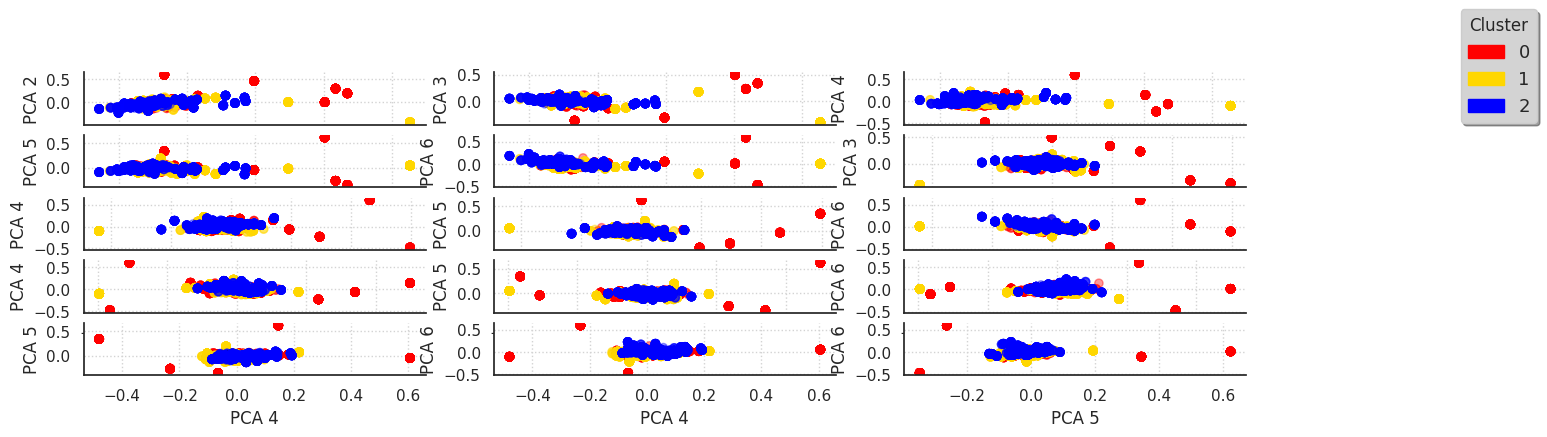

In [35]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(10):
    for iy in range(ix+1, 6):    
        increment += 1
        ax = fig.add_subplot(10,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        print(increment,ix,iy)
        
#         if increment == 15: break
#     if increment == 15: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(3):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

In [101]:
datasetAll.printSchema()

root
 |-- content: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- label: integer (nullable = true)



In [103]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 11.0 MB/s eta 0:00:0000:0100:01


In [104]:
import plotly.express as px

In [110]:
mat.to_csv('test.csv')

In [10]:
df.select(ex)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- thank_count: string (nullable = true)
 |-- content: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- spid: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- created_by: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- seller: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- timeline: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

